# CogPonder: A Model-Agnostic Approach to Response Times in Cognitive Tasks

Of our interest is a simultaneous model of speed and accuracy of human responses.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrate a model-agnostic neural network that produces the speed-accuracy of the human decision making.

The network iterates over a recurrent decision model, terminating only when it reaches a halting step. Halting step is a decision step that is made when the network is confident enough to make a decision. The network is trained to minimize the difference between the human response time and the network's response time.


## Tasks

### 2-back Task

The subject is presented with a sequence of letters, and are asked to respond with "target" button whe the current stimulus matches the one from n steps earlier in the sequence. The load factor n can be adjusted to make the task more or less difficult.

We use a mock 2-back dataset to evaluate the architecture. The mock dataset includes trial-level $X$, $responses$, $targets$, and $response\_times$ for each subject.


### Decision Model

We want to learn a supervised approximation of the $X \to y$ as follows:

$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the decision model. The learning process continues for a maximum of $N_{max}$ steps. For brevity, each time step is considered 100ms. ($\lambda_n$) is the halting probability in step $n$ (given a Bernoulli distribution).

In case of the 2-back task, X is a moving window of recent 2 stimuli symbols, e.g., A, B, C, D, ...; and $y$ is either MATCH or NON_MATCH.

### Output

The *PonderNet* model produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch.


### Criterion

$L = L_{rec} + L_{reg} + L_{target} + L_{non\_target}$ 


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from cogponder import NBackDataset, PonderNet, ICOM, evaluate

## Data

In [2]:


# generate mock n-back data

N_STIMULI = 6

dataset = NBackDataset(n_subjects=2, n_trials=200, n_stimuli=N_STIMULI)

X, targets, responses, response_steps = dataset[0]
dataset = TensorDataset(X, targets.float(), responses, response_steps)

In [3]:
# evaluate the model

N_EPOCHS = 1000
MAX_STEPS = response_steps.detach().max() + 10
N_OUTPUTS = torch.unique(targets).size()[0]
LAMBDA_P = 1 / MAX_STEPS #response_steps.detach().float().mean()

model = PonderNet(ICOM, N_STIMULI+1, N_STIMULI, N_OUTPUTS, MAX_STEPS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

results = evaluate(model, dataset, optimizer, n_epochs=N_EPOCHS,
                   lambda_p=LAMBDA_P,
                   batch_size=4, max_steps=MAX_STEPS)

model, X_train, X_test, y_train, y_test, r_train, r_test, rt_train, rt_test = results


Epochs: 100%|██████████| 1000/1000 [00:33<00:00, 30.05it/s]


In [4]:

with torch.no_grad():
    model.eval()
    rt_train_pred = model(X_train)[2].detach()
    rt_test_pred = model(X_test)[2].detach()

    print('TRUE TRAIN:', rt_test.detach().tolist(), '\nPRED TRAIN:',  rt_test_pred.tolist())

TRUE TRAIN: [8, 1, 1, 1, 1, 1, 1, 1, 3, 1, 8, 1, 1, 8, 1, 2, 1, 3, 5, 2, 1, 7, 1, 4, 2, 1, 2, 1, 4, 1, 3, 4, 2, 1, 4, 4, 3, 6, 2, 1] 
PRED TRAIN: [8, 9, 5, 10, 9, 8, 8, 9, 5, 10, 3, 6, 11, 6, 8, 7, 8, 7, 7, 6, 12, 10, 8, 8, 10, 11, 6, 10, 16, 4, 11, 8, 3, 14, 7, 17, 7, 6, 8, 5]


In [5]:
rt_test_pred.median(), rt_test.float().median(), rt_train_pred.median(), rt_train.float().median()


(tensor(8, dtype=torch.int32),
 tensor(2.),
 tensor(8, dtype=torch.int32),
 tensor(2.))

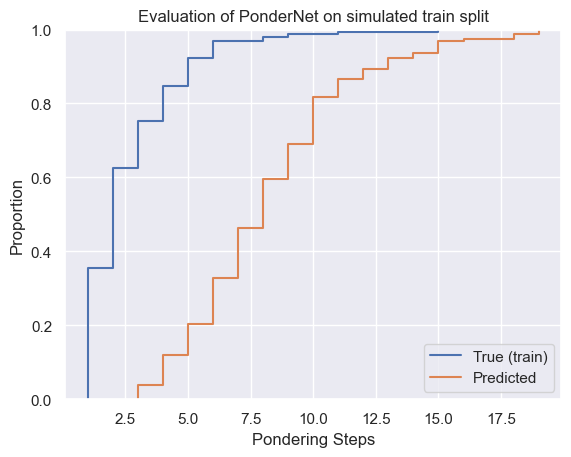

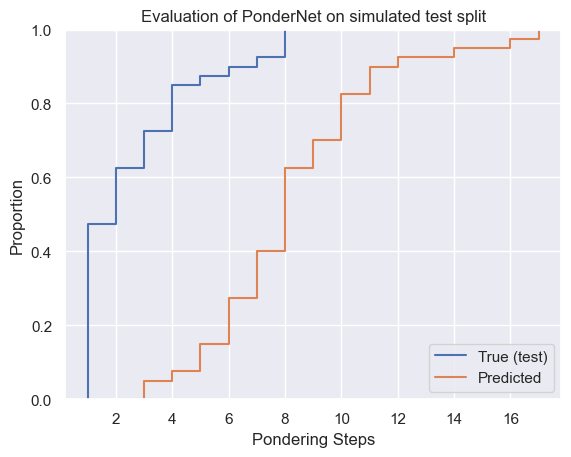

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(rt_train.detach(), label='True (train)')
sns.ecdfplot(rt_train_pred.detach(), label='Predicted')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('Pondering Steps')

plt.legend()
plt.show()

sns.ecdfplot(rt_test.detach(), label='True (test)')
sns.ecdfplot(rt_test_pred.detach(), label='Predicted')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('Pondering Steps')
plt.legend()
plt.show()

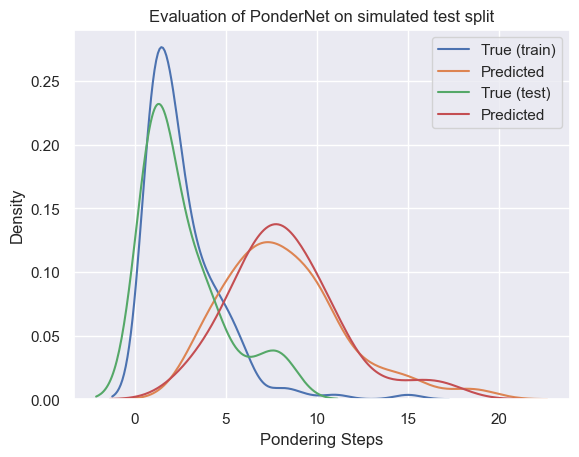

In [7]:

sns.kdeplot(rt_train.detach(), label='True (train)')
sns.kdeplot(rt_train_pred.detach(), label='Predicted')

sns.kdeplot(rt_test.detach(), label='True (test)')
sns.kdeplot(rt_test_pred.detach(), label='Predicted')


plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('Pondering Steps')
plt.legend()
plt.show()